### Crack Segmentation on deep crack dataset.


### Dataset = DEEP CRACK
### Optimiser=adam_and_beyond



### Importing the neccessary libraries and mounting the google drive

In [ ]:
! nvidia-smi

Wed Jun 26 01:19:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Loading the dataset

### Input Pipeline
* The data is loaded with its respective masks
* The data is then shuffled
* Splited & Divided into train,test and validation sets








In [ ]:
train_image_dir = r'/content/drive/MyDrive/DeepCrack/train_img'
train_mask_dir = r'/content/drive/MyDrive/DeepCrack/train_lab'

test_image_dir = r'/content/drive/MyDrive/DeepCrack/test_img'
test_mask_dir = r'/content/drive/MyDrive/DeepCrack/test_lab'

In [ ]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))
print('\n')
print("Number of testing images : ", len(test_image_paths))
print("Number of testing masks : ", len(test_mask_paths))



Number of training images :  300
Number of training masks :  300


Number of testing images :  237
Number of testing masks :  237


In [ ]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)

train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [ ]:
# Splitting
train_image_files = train_image_paths[:270]
train_mask_files = train_mask_paths[:270]

valid_image_files = train_image_paths[270:]
valid_mask_files = train_mask_paths[270:]

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))


270 270
30 30


## Generator creation
* A custom generator is created which combines the  image with its repective masks.
* All data is augmented using albumentation library.
* Random flips and rotations along with more attributes of the albumentation library are used to augment the images present in the training data

In [ ]:
batch_size = 10
img_dim=(256, 256)

In [ ]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(128, 128), augment=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augment = augment

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  augmentations = Compose(
    [
      Flip(p=0.7),
      Rotate(p=0.7),
      OneOf([
              RandomContrast(),
              RandomGamma(),
              RandomBrightness()
            ], p=0.3),
      OneOf([
              ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
              GridDistortion(),
              OpticalDistortion(distort_limit=2, shift_limit=0.5)
            ], p=0.3),
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (self.img_dim[1], self.img_dim[0])) for file_name in batch_x])
      batch_y = np.array([(cv2.resize(cv2.imread(file_name, -1), (self.img_dim[1], self.img_dim[0]))>0).astype(np.uint8) for file_name in batch_y])

      if self.augment is True:
        aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255, batch_y/1

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:
train_generator = Generator(train_image_files, train_mask_files)
validation_generator = Generator(valid_image_files, valid_mask_files)
test_generator=Generator(test_image_paths,test_mask_paths)

In [ ]:
for i, j in train_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [ ]:
for i, j in validation_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [ ]:
for i,j in test_generator:
  break
print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


### Plotting of the unaugmented images along with known images

> Añadir blockquote



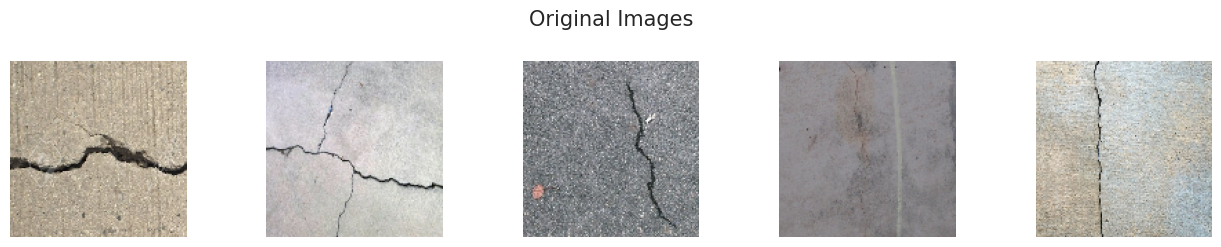

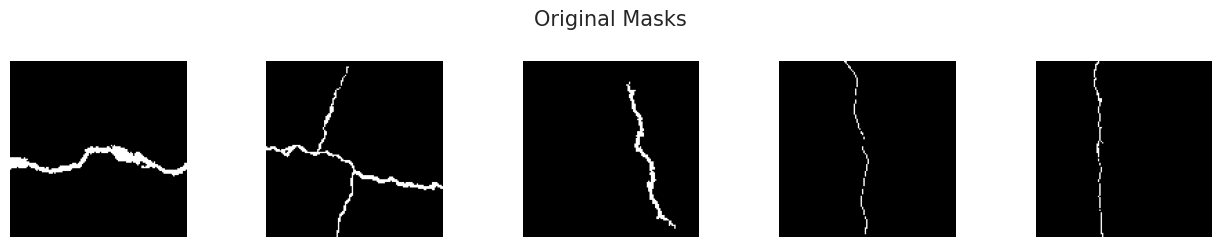

In [ ]:
# Train generator samples (Un-augmented)
for i, j in train_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

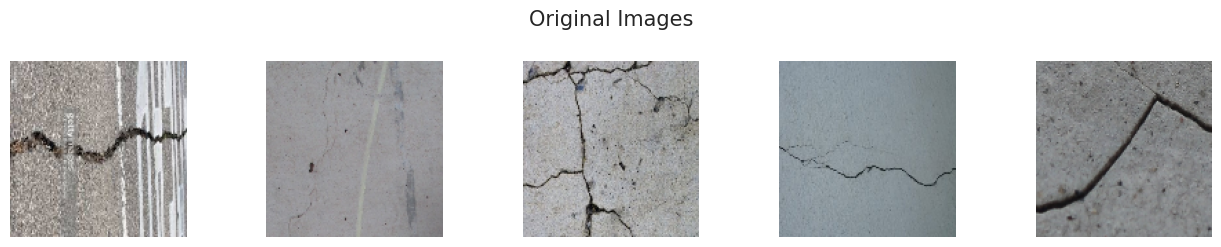

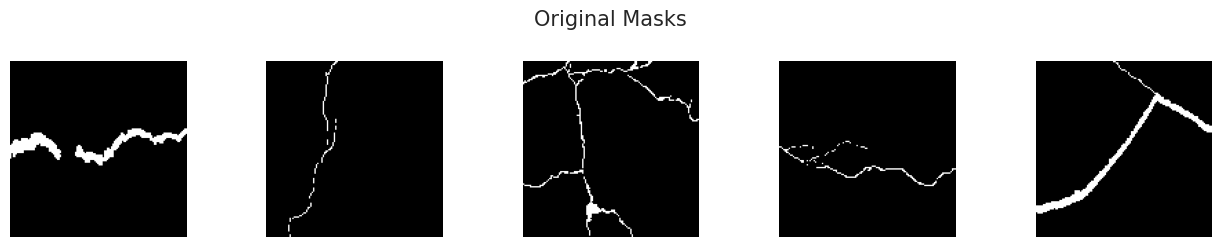

In [ ]:
# Validation generator samples (Un-augmented)
for i, j in validation_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

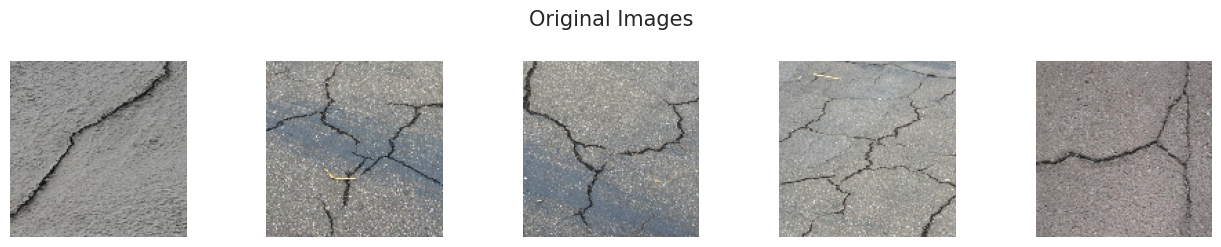

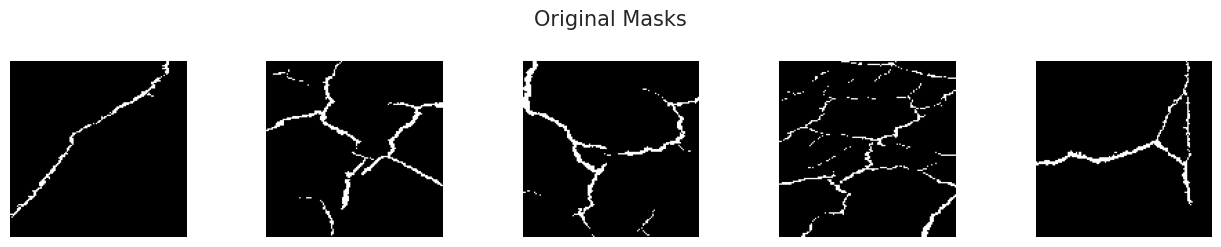

In [ ]:
# test generator samples (Un-augmented)
for i, j in test_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
tg = Generator(train_image_files, train_mask_files, batch_size, img_dim, augment = True)
vg = Generator(valid_image_files, valid_mask_files, batch_size, img_dim, augment = False)
testg=Generator(test_image_paths,test_mask_paths,batch_size,img_dim,augment=False)

In [ ]:
for i, j in tg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
for i, j in vg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
for i, j in testg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


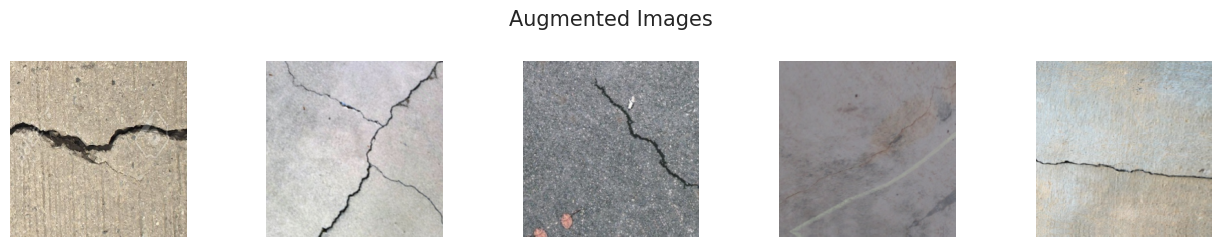

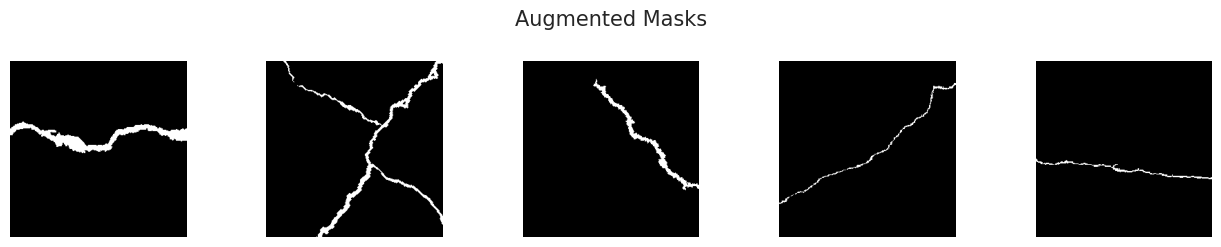

In [ ]:
# Augmented train
for i, j in tg:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

#Model

In [ ]:
import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Input, Activation, Concatenate
from keras.regularizers import l2

In [ ]:
# BatchNormalization and Activation
def BN_Act(x, act = True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

In [ ]:
# conv2d block
def conv2d_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    conv = BN_Act(x)
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(conv)
    return conv

In [ ]:
# Fixed layer
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
    conv = conv2d_block(conv, filters, kernel_size = kernel_size, padding = padding, strides = strides)

    #skip
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection

    output = Add()([conv, shortcut])
    return output

In [ ]:
#Residual Block
def residual_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    res = conv2d_block(x, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    res = conv2d_block(res, filters, kernel_size = kernel_size, padding = padding, strides = 1)

    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection

    output = Add()([shortcut, res])
    return output

In [ ]:
#Upsample concatenation block
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [ ]:
# Complete model Architecture
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_dim[0], img_dim[1], 3))

    ## Encoder/downsampling/contracting path
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides = 2)
    e3 = residual_block(e2, f[2], strides = 2)
    e4 = residual_block(e3, f[3], strides = 2)
    e5 = residual_block(e4, f[4], strides = 2)

    ## Bridge/Bottleneck
    b0 = conv2d_block(e5, f[4], strides = 1)
    b1 = conv2d_block(b0, f[4], strides = 1)

    ## Decoder/upsampling/expansive path
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = Conv2D(1, (1, 1), padding = "same", activation = "sigmoid")(d4)
    model = Model(inputs, outputs)
    return model

In [ ]:
K.clear_session()
model = ResUNet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0

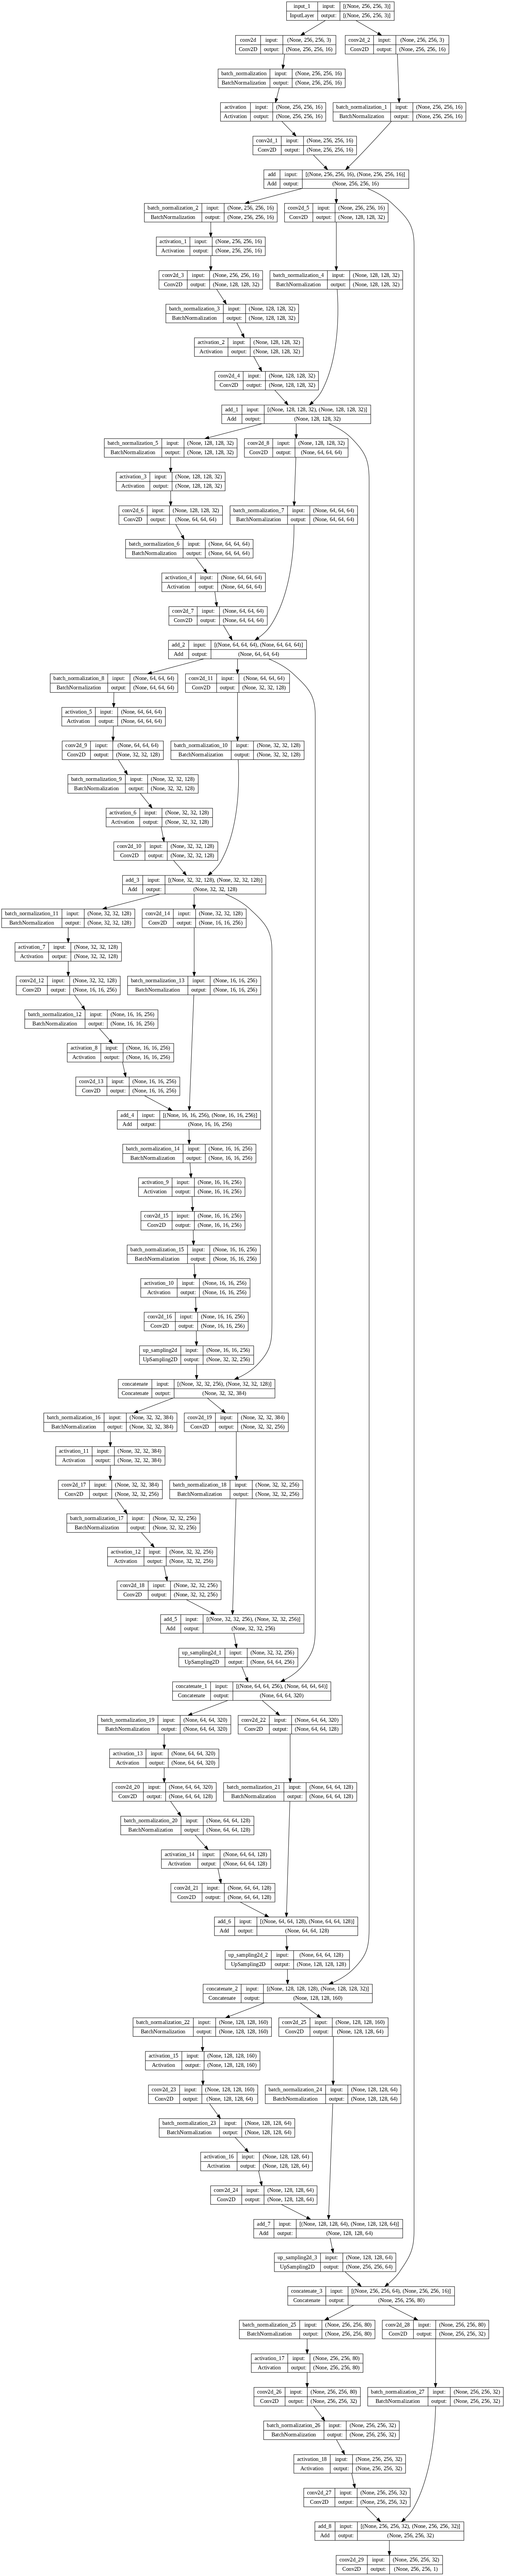

In [ ]:
from tensorflow.keras.utils import  plot_model

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=100,
)

# Loss Function


In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

# def bce_dice_loss(y_true, y_pred):

#     return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Learning Rate Schedular And other callbacks

In [ ]:
def lr_schedule(epoch):
    lr =0.001
    if epoch >150:
        lr *=2**-1
    elif epoch >80:
        lr *=2**(-1)
    elif epoch >50:
        lr *=2**(-1)
    elif epoch >30:
        lr *=2**(-1)

    print('Learning rate: ', lr)
    return lr

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

In [ ]:

import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-8)

callbacks = [lr_reducer, lr_scheduler]


### Compiling with adam and beyond

In [ ]:
import tensorflow as tf
learning_rate = 0.0035
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)
model.compile(optimizer =optimiser , loss = dice_coef_loss, metrics = ['accuracy', IOU, dice_coef])

Learning rate:  0.001


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Adam_and_beyond.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Training

In [ ]:
train_steps = len(train_image_files)//batch_size
valid_steps = len(valid_image_files)//batch_size

history = model.fit(
    tg,
    steps_per_epoch=train_steps,
    initial_epoch = 0,
    epochs=10, #inicialmente era 100
    validation_data = vg,
    validation_steps = valid_steps,callbacks=callbacks)

Learning rate:  0.001
Epoch 1/10
27/27 [==============================] - 10s 363ms/step - loss: 0.2621 - accuracy: 0.9819 - IOU: 0.5959 - dice_coef: 0.7379 - val_loss: 0.9081 - val_accuracy: 0.9661 - val_IOU: 0.0143 - val_dice_coef: 0.0919 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
27/27 [==============================] - 8s 278ms/step - loss: 0.2576 - accuracy: 0.9823 - IOU: 0.5996 - dice_coef: 0.7424 - val_loss: 0.9995 - val_accuracy: 0.9656 - val_IOU: 4.6693e-12 - val_dice_coef: 4.9041e-04 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
27/27 [==============================] - 8s 298ms/step - loss: 0.2310 - accuracy: 0.9841 - IOU: 0.6308 - dice_coef: 0.7690 - val_loss: 0.9604 - val_accuracy: 0.9662 - val_IOU: 0.0161 - val_dice_coef: 0.0396 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
27/27 [==============================] - 9s 319ms/step - loss: 0.2544 - accuracy: 0.9823 - IOU: 0.6021 - dice_coef: 0.7456 - val_loss: 0.9990 - val_accuracy: 0.9656 - val_IOU: 1.0874e-04 - val_dice_c

In [ ]:
history = model.fit(
    tg,
    steps_per_epoch=train_steps,
    initial_epoch =6, #inicialmnte era 60
    epochs=10, #inicialmnte era 80
    validation_data = vg,
    validation_steps = valid_steps,callbacks=callbacks)

Learning rate:  0.001
Epoch 7/10
27/27 [==============================] - 9s 319ms/step - loss: 0.1946 - accuracy: 0.9868 - IOU: 0.6775 - dice_coef: 0.8054 - val_loss: 0.5788 - val_accuracy: 0.9751 - val_IOU: 0.2721 - val_dice_coef: 0.4212 - lr: 0.0010
Learning rate:  0.001
Epoch 8/10
27/27 [==============================] - 9s 313ms/step - loss: 0.1997 - accuracy: 0.9864 - IOU: 0.6704 - dice_coef: 0.8003 - val_loss: 0.4158 - val_accuracy: 0.9790 - val_IOU: 0.4382 - val_dice_coef: 0.5842 - lr: 0.0010
Learning rate:  0.001
Epoch 9/10
27/27 [==============================] - 8s 285ms/step - loss: 0.2039 - accuracy: 0.9863 - IOU: 0.6667 - dice_coef: 0.7961 - val_loss: 0.4669 - val_accuracy: 0.9787 - val_IOU: 0.3695 - val_dice_coef: 0.5331 - lr: 0.0010
Learning rate:  0.001
Epoch 10/10
27/27 [==============================] - 9s 319ms/step - loss: 0.2285 - accuracy: 0.9844 - IOU: 0.6336 - dice_coef: 0.7715 - val_loss: 0.4859 - val_accuracy: 0.9773 - val_IOU: 0.3484 - val_dice_coef: 0.5141 

In [ ]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

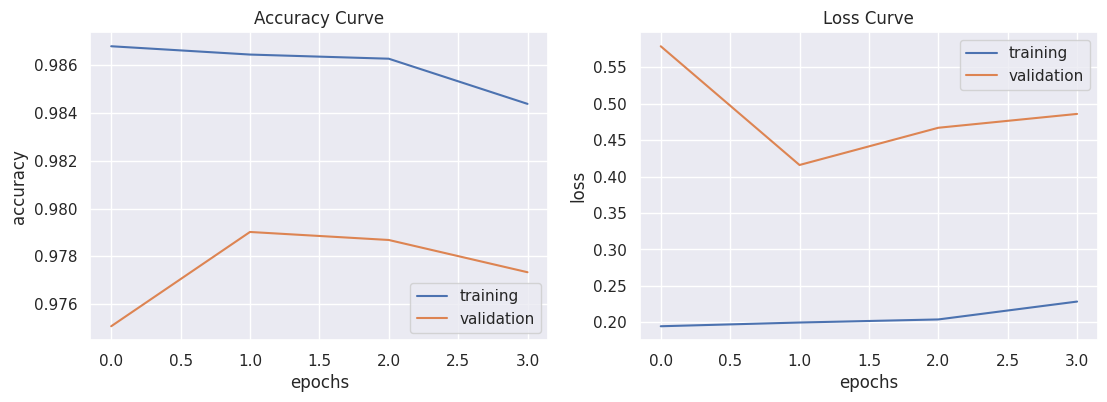

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [ ]:
train_dice = history.history['dice_coef']
valid_dice = history.history['val_dice_coef']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

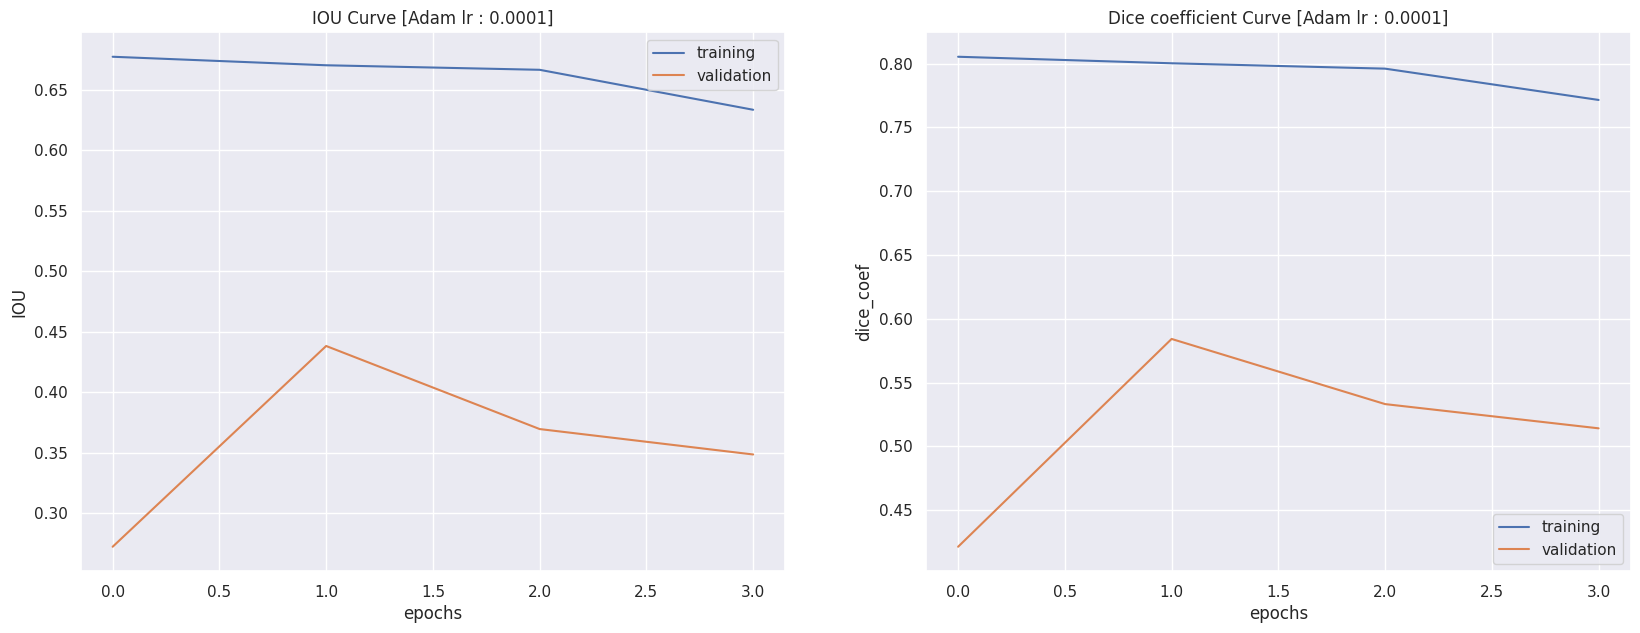

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve [Adam lr : 0.0001]')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve [Adam lr : 0.0001]')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()

## Testing

In [ ]:
test_generator = Generator(valid_image_files, valid_mask_files,30 , img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

1/1 [==============================] - 12s 12s/step


In [ ]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9773

Precision: 0.9493

Recall: 0.3613

F1-Score: 0.5234

Sensitivity: 0.3613

Specificity: 0.9993

AUC: 0.6506

IOU: 0.3545

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.98      1.00      0.99   1898357
        True       0.95      0.36      0.52     67723

    accuracy                           0.98   1966080
   macro avg       0.96      0.68      0.76   1966080
weighted avg       0.98      0.98      0.97   1966080



In [ ]:
test_generator = Generator(test_image_paths, test_mask_paths,237, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

8/8 [==============================] - 18s 983ms/step


In [ ]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9690

Precision: 0.9887

Recall: 0.3630

F1-Score: 0.5310

Sensitivity: 0.3630

Specificity: 0.9998

AUC: 0.6508

IOU: 0.3615

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.97      1.00      0.98  14780073
        True       0.99      0.36      0.53    751959

    accuracy                           0.97  15532032
   macro avg       0.98      0.68      0.76  15532032
weighted avg       0.97      0.97      0.96  15532032



In [ ]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9859

Precision: 0.9214

Recall: 0.7739

F1-Score: 0.8412

Sensitivity: 0.7739

Specificity: 0.9966

AUC: 0.9115

IOU: 0.7260

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.99      1.00      0.99  14780073
        True       0.92      0.77      0.84    751959

    accuracy                           0.99  15532032
   macro avg       0.96      0.89      0.92  15532032
weighted avg       0.99      0.99      0.99  15532032



In [ ]:

# Mostrar la imagen original, la máscara verdadera y la máscara predicha
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x_test[0], cmap='gray')
ax[0].set_title('Imagen Original')
ax[0].axis('off')

ax[1].imshow(y_test[0].squeeze(), cmap='gray')
ax[1].set_title('Máscara Verdadera')
ax[1].axis('off')

ax[2].imshow(y_pred[0].squeeze(), cmap='gray')
ax[2].set_title('Máscara Predicha')
ax[2].axis('off')

plt.show()